In [33]:
import psycopg2, psycopg2.extensions, psycopg2.extras
import numpy as np
import matplotlib.pyplot as plt

In [87]:
################
#priklop na bazo
psycopg2.extensions.register_type(psycopg2.extensions.UNICODE) # se znebimo problemov s sumniki
baza = psycopg2.connect(database='sem2018_leonh', host='baza.fmf.uni-lj.si', user='javnost', password='javnogeslo')
baza.set_isolation_level(psycopg2.extensions.ISOLATION_LEVEL_AUTOCOMMIT) # onemogocimo transakcije
cur = baza.cursor(cursor_factory=psycopg2.extras.DictCursor)

################
#test priklopa na bazo
def test(posta):
    cur.execute('''
                    SELECT * FROM uporabnik WHERE username=%s
                ''', [posta])
    return (cur.fetchall())

print(test('sgalea0')[0][0])

sgalea0


# Laplacov mehanizem za numerične podatke (perturbacije podatkovne baze)

In [78]:
#izracun diametra (preveri veljavnost!!)
def diameter(data):
    return max(abs(x[0] - x[1]) for x in zip(data[1:], data))

In [79]:
#baza = [1000, 2000, 3000, 1200, 500]  #tole so kao place
baza = [1.6,1.92,2.02,1.78,1.80] #tole so kao visine

epsilon = 2
delta = 0.5
b = diameter(baza)/(epsilon - np.log(1-delta))

df_baza = map(lambda elem: elem + np.random.laplace(0,b), baza)

In [80]:
print(baza)
print(df_baza)

[1.6, 1.92, 2.02, 1.78, 1.8]
[1.5784841417392896, 1.8215399133391517, 1.8441473212623074, 1.8080402526096493, 1.7892614205679984]


In [81]:
print(sum(baza)/len(baza))
print(sum(df_baza)/len(df_baza))

1.824
1.7682946099


# Primer funkcijskih podatkov - kernel density estimation

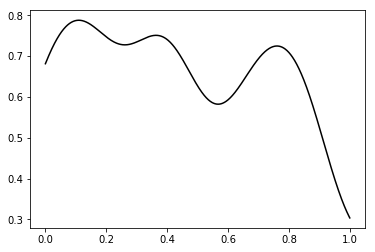

In [84]:
seznam = [numpy.random.normal(0.3,0.5) for _ in range(100)] #+ [numpy.random.normal(0.7,1) for _ in range(50)]

def tmp(x,):
    return x

def f(x, h=0.1,d=1):
    return (1/(len(seznam)*(2*np.pi*h**2)**(d*0.5)))*sum(map(lambda elem: np.exp(-((elem-x)**2)/(2*h**2)),seznam))

f(0.3)

t1 = np.arange(0, 1,0.001)

plt.plot(t1, f(t1), 'k')

plt.show()

In [75]:
print(seznam[:2])
print(map(lambda elem: np.exp(-((elem-0.2)**2)/(2*h**2)),seznam)[:2])

[2.2995011027979304, -1.6692570326003957]
[1.9211517864265509e-96, 1.3369279017133246e-76]


In [63]:
np.exp(-((seznam[0]-0.2)**2)/(2*h**2))

5.2554870187714282e-20

# Delovna verzija

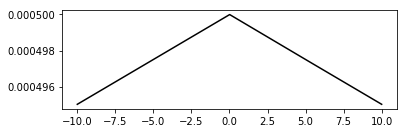

In [56]:
import numpy as np
import matplotlib.pyplot as plt

def f(x):
    return np.exp(-abs(x)/b) / (2*b)

t1 = np.arange(-10, 10.0, 0.001)


plt.figure(1)
plt.subplot(211)
plt.plot(t1, f(t1), 'k')

plt.show()